# Clusterizacao - Case ImdbMovies

# IMDb TOP 250 Movies
![An image](https://static.amazon.jobs/teams/53/images/IMDb_Header_Page.jpg?1501027252)

**Este projeto consiste em treinar um sistema de recomendação de filmes utilizando as informações referentes aos top 250 filmes melhor avaliados pelo público na plataforma IMDb.**
*   A extração dos dados será feita por técnicas de web scraping (crawler).
*   O objetivo principal será agrupar os 250 filmes em "n" clusters classificados a partir das suas sinopses, aplicando técnicas de processamento de texto e algoritmos de clusterização.
*   Ao final, teremos um sistemas de recomendação baseado na similaridade das sinopses, e não apenas dos generos.

**Exemplo de aplicação prática: usuários receberão recomendações de filmes que estejam no mesmo cluster de sinopses de outros filmes que ele já tenha curtido.**

# Import das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import requests
from pprint import pprint
from bs4 import BeautifulSoup
import re
import json
from urllib.request import Request, urlopen
from lxml import html
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Web Scraping / Crawler

In [2]:
#return only 25 first movies, because it doesn't wait the complete render of the page
userAgents=[
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/74.0.3729.157 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.1.1 Safari/605.1.15"]

url = 'https://www.imdb.com/chart/top/?ref_=nv_mv_250'
response = requests.get(url, headers={"User-agent": userAgents[1]})
response


<Response [200]>

In [3]:
pprint(response)

<Response [200]>


In [4]:
html = response.text
html

'<!DOCTYPE html><html lang="en-US" xmlns:og="http://opengraphprotocol.org/schema/" xmlns:fb="http://www.facebook.com/2008/fbml"><head><meta charSet="utf-8"/><meta name="viewport" content="width=device-width"/><script>if(typeof uet === \'function\'){ uet(\'bb\', \'LoadTitle\', {wb: 1}); }</script><script>window.addEventListener(\'load\', (event) => {\n        if (typeof window.csa !== \'undefined\' && typeof window.csa === \'function\') {\n            var csaLatencyPlugin = window.csa(\'Content\', {\n                element: {\n                    slotId: \'LoadTitle\',\n                    type: \'service-call\'\n                }\n            });\n            csaLatencyPlugin(\'mark\', \'clickToBodyBegin\', 1755294016485);\n        }\n    })</script><title>IMDb Top 250 movies</title><meta name="description" content="As rated by regular IMDb voters." data-id="main"/><meta name="google-site-verification" content="0cadf7898134e79b"/><meta name="msvalidate.01" content="C1DACEF2769068C0B0D

In [5]:
bs = BeautifulSoup(html)
pprint(bs)

<!DOCTYPE html>
<html lang="en-US" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://opengraphprotocol.org/schema/"><head><meta charset="utf-8"/><meta content="width=device-width" name="viewport"/><script>if(typeof uet === 'function'){ uet('bb', 'LoadTitle', {wb: 1}); }</script><script>window.addEventListener('load', (event) => {
        if (typeof window.csa !== 'undefined' && typeof window.csa === 'function') {
            var csaLatencyPlugin = window.csa('Content', {
                element: {
                    slotId: 'LoadTitle',
                    type: 'service-call'
                }
            });
            csaLatencyPlugin('mark', 'clickToBodyBegin', 1755294016485);
        }
    })</script><title>IMDb Top 250 movies</title><meta content="As rated by regular IMDb voters." data-id="main" name="description"/><meta content="0cadf7898134e79b" name="google-site-verification"/><meta content="C1DACEF2769068C0B0D2687C9E5105FA" name="msvalidate.01"/><meta content="m

## Title EN

In [6]:
titles = bs.find_all('h3', attrs={'class':'ipc-title__text'})
for t in titles:
  print(t)

<h3 class="ipc-title__text ipc-title__text--reduced">IMDb Charts</h3>
<h3 class="ipc-title__text ipc-title__text--reduced">1. The Shawshank Redemption</h3>
<h3 class="ipc-title__text ipc-title__text--reduced">2. The Godfather</h3>
<h3 class="ipc-title__text ipc-title__text--reduced">3. The Dark Knight</h3>
<h3 class="ipc-title__text ipc-title__text--reduced">4. The Godfather Part II</h3>
<h3 class="ipc-title__text ipc-title__text--reduced">5. 12 Angry Men</h3>
<h3 class="ipc-title__text ipc-title__text--reduced">6. The Lord of the Rings: The Return of the King</h3>
<h3 class="ipc-title__text ipc-title__text--reduced">7. Schindler's List</h3>
<h3 class="ipc-title__text ipc-title__text--reduced">8. Pulp Fiction</h3>
<h3 class="ipc-title__text ipc-title__text--reduced">9. The Lord of the Rings: The Fellowship of the Ring</h3>
<h3 class="ipc-title__text ipc-title__text--reduced">10. The Good, the Bad and the Ugly</h3>
<h3 class="ipc-title__text ipc-title__text--reduced">11. Forrest Gump</h

In [7]:
list_title_en = []
for x in titles:
  if x.text != 'IMDb Charts' and x.text != 'Recently viewed':
    tit = (x.text).split('.')[-1].strip()
    list_title_en.append(tit)
print(len(list_title_en))
list_title_en

25


['The Shawshank Redemption',
 'The Godfather',
 'The Dark Knight',
 'The Godfather Part II',
 '12 Angry Men',
 'The Lord of the Rings: The Return of the King',
 "Schindler's List",
 'Pulp Fiction',
 'The Lord of the Rings: The Fellowship of the Ring',
 'The Good, the Bad and the Ugly',
 'Forrest Gump',
 'The Lord of the Rings: The Two Towers',
 'Fight Club',
 'Inception',
 'Star Wars: Episode V - The Empire Strikes Back',
 'The Matrix',
 'Goodfellas',
 'Interstellar',
 "One Flew Over the Cuckoo's Nest",
 'Se7en',
 "It's a Wonderful Life",
 'The Silence of the Lambs',
 'Seven Samurai',
 'Saving Private Ryan',
 'The Green Mile']

## Year

In [8]:
list_years = []
# years = bs.find_all('div', attrs={'class':'sc-14dd939d-5 cPiUKY cli-title-metadata'})
years = bs.find_all('div', attrs={'class':'sc-b189961a-7 btCcOY cli-title-metadata'})

for y in years:
  year = y.find('div', attrs={'class':'sc-b189961a-7 btCcOY cli-title-metadata'})
for year in years:
    # print(year.text)
  list_years.append(year.text[:4])
display(len(list_years))
list_years

0

[]

## Rating

In [9]:
list_rating = []

# Step 3: Locate the relevant element
rating_span = bs.find_all('span', class_='ipc-rating-star--rating')
for x in rating_span:
  list_rating.append(x.text)
display(len(list_rating))
list_rating

25

['9.3',
 '9.2',
 '9.1',
 '9.0',
 '9.0',
 '9.0',
 '9.0',
 '8.8',
 '8.9',
 '8.8',
 '8.8',
 '8.8',
 '8.8',
 '8.8',
 '8.7',
 '8.7',
 '8.7',
 '8.7',
 '8.7',
 '8.6',
 '8.6',
 '8.6',
 '8.6',
 '8.6',
 '8.6']

## Genre, Title PT & Year

In [10]:
list_links = []
for a in bs.find_all('a', href=True):
  if '/title/' in a['href'] and 'https://www.imdb.com/'+a['href'] not in list_links:
    list_links.append(('https://www.imdb.com/'+a['href'])[:-15])

#Remove duplicates
list_links = list(dict.fromkeys(list_links))
list_links = list_links[1:]
display(len(list_links))
list_links[:5]

25

['https://www.imdb.com//title/tt0111161/',
 'https://www.imdb.com//title/tt0068646/',
 'https://www.imdb.com//title/tt0468569/',
 'https://www.imdb.com//title/tt0071562/',
 'https://www.imdb.com//title/tt0050083/']

In [11]:
headers = {
          'authority': 'www.amazon.com.br',
          'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
          'accept-language': 'pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7',
          'cache-control': 'max-age=0',
          'device-memory': '8',
          'downlink': '10',
          'dpr': '1.875',
          'ect': '4g',
          'rtt': '50',
          'sec-ch-device-memory': '8',
          'sec-ch-dpr': '1.875',
          'sec-ch-ua': '"Chromium";v="110", "Not A(Brand";v="24", "Google Chrome";v="110"',
          'sec-ch-ua-mobile': '?0',
          'sec-ch-ua-platform': '"Windows"',
          'sec-ch-ua-platform-version': '"10.0.0"',
          'sec-ch-viewport-width': '455',
          'sec-fetch-dest': 'document',
          'sec-fetch-mode': 'navigate',
          'sec-fetch-site': 'none',
          'sec-fetch-user': '?1',
          'upgrade-insecure-requests': '1',
          'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36',
          'viewport-width': '455',
          }
############################################################
list_genre = []
list_title_pt = []
list_year = []
list_sinopse = []

for link in list_links:
  time.sleep(.5)
  response = requests.get(link, headers = headers)
  html = response.content
  soup = BeautifulSoup(html, "html.parser")

  #genre
  try:
    for genre in soup.find('span', {'class':'ipc-chip__text'}):
      genre = genre.text
      list_genre.append(genre)
  except:
      list_genre.append(np.nan)
      print('Nan')

  #title_PT and year
  try:
    for x in soup.find('title'):
      #title_pt
      title_pt = (x.text)[:-14].strip()
      list_title_pt.append(title_pt)
      #year
      year = (x.text)[-12:-8].strip()
      list_year.append(year)

  except:
    list_title_pt.append(np.nan)
    list_year.append(np.nan)

  #sinopse
  try:
    for sin in soup.find('span', {"data-testid":"plot-xl"}):
      sinopse = sin.text
      list_sinopse.append(sinopse)
  except:
    list_sinopse.append(np.nan)

  print(genre, title_pt, year, sinopse[:20])

display(len(list_genre), len(list_title_pt), len(list_year), len(list_sinopse))
print(list_genre[:5])
print(list_title_pt[:5])
print(list_year[:5])
display(list_sinopse[:2])

Drama de época Um Sonho de Liberdade 1994 Dois homens presos s
Épico O Poderoso Chefão 1972 O patriarca idoso de
Ação épica Batman: O Cavaleiro das Trevas 2008 Agora com a ajuda do
Épico O Poderoso Chefão: Parte II 1974 O início da vida e d
Drama jurídico 12 Homens e uma Sentença 1957 O julgamento de um a
Ação épica O Senhor dos Anéis: O Retorno do Rei 2003 Gandalf e Aragorn li
Docudrama A Lista de Schindler 1993 Na Polônia ocupada p
Comédia de humor negro Pulp Fiction: Tempo de Violência 1994 As vidas de dois ass
Ação épica O Senhor dos Anéis: A Sociedade do Anel 2001 Um manso hobbit do C
Ação épica Três Homens em Conflito 1966 Um impostor se junta
Épico Forrest Gump: O Contador de Histórias 1994 Os governos dos pres
Ação épica O Senhor dos Anéis: As Duas Torres 2002 Enquanto Frodo e Sam
Comédia de humor negro Clube da Luta 1999 Um trabalhador de es
Ação épica A Origem 2010 Um ladrão que rouba 
Ação épica Star Wars: Episódio V - O Império Contra-Ataca 1980 Depois que a Aliança
Ação ép

25

25

25

25

['Drama de época', 'Épico', 'Ação épica', 'Épico', 'Drama jurídico']
['Um Sonho de Liberdade', 'O Poderoso Chefão', 'Batman: O Cavaleiro das Trevas', 'O Poderoso Chefão: Parte II', '12 Homens e uma Sentença']
['1994', '1972', '2008', '1974', '1957']


['Dois homens presos se reúnem ao longo de vários anos, encontrando consolo e eventual redenção através de atos de decência comum.',
 'O patriarca idoso de uma dinastia do crime organizado transfere o controle de seu império clandestino para seu filho relutante.']

In [12]:
list_genre

['Drama de época',
 'Épico',
 'Ação épica',
 'Épico',
 'Drama jurídico',
 'Ação épica',
 'Docudrama',
 'Comédia de humor negro',
 'Ação épica',
 'Ação épica',
 'Épico',
 'Ação épica',
 'Comédia de humor negro',
 'Ação épica',
 'Ação épica',
 'Ação épica',
 'Crime verdadeiro',
 'Aventura épica',
 'Drama médico',
 'Assassino em série',
 'Drama psicológico',
 'Assassino em série',
 'Ação épica',
 'Drama de época',
 'Drama de época']

## DataFrame

In [14]:
df = pd.DataFrame({'title_pt':list_title_pt,
                   'title_en':list_title_en,
                   # 'year':list_years,
                   'rating':list_rating,
                   'genre':list_genre,
                   'sinopse':list_sinopse})
#path_export = '/content/drive/MyDrive/Web_Mining_and_Crawler'
# df.to_csv(f'{path_to_export}/top250_movies.csv', sep = ';',index = False)
display(df.head())

title_pt                  title_en rating  \
0           Um Sonho de Liberdade  The Shawshank Redemption    9.3   
1               O Poderoso Chefão             The Godfather    9.2   
2  Batman: O Cavaleiro das Trevas           The Dark Knight    9.1   
3     O Poderoso Chefão: Parte II     The Godfather Part II    9.0   
4        12 Homens e uma Sentença              12 Angry Men    9.0   

            genre                                            sinopse  
0  Drama de época  Dois homens presos se reúnem ao longo de vário...  
1           Épico  O patriarca idoso de uma dinastia do crime org...  
2      Ação épica  Agora com a ajuda do tenente Jim Gordon e do p...  
3           Épico  O início da vida e da carreira de Vito Corleon...  
4  Drama jurídico  O julgamento de um assassinato em Nova Iorque ...

# Concatenando com a base de filmes historica

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
df_historico = pd.read_csv('/content/drive/MyDrive/Front End e Mobile Development/2025/20250815 - Aula02/all_movies.csv', sep = ';')
df = pd.concat([df_historico, df])
df.drop_duplicates(inplace = True)
df.reset_index(drop = True, inplace = True)
df.head()

title_pt                     title_en    year rating  \
0                          Barbie                       Barbie  2023.0    7.4   
1           Um Sonho de Liberdade  1. The Shawshank Redemption  1994.0    9.3   
2               O Poderoso Chefão             2. The Godfather  1972.0    9.2   
3  Batman: O Cavaleiro das Trevas           3. The Dark Knight  2008.0    9.0   
4            O Poderoso Chefão II     4. The Godfather Part II  1974.0    9.0   

      genre                                            sinopse  
0  Aventura  Viver na Terra da Barbie é ser um ser perfeito...  
1     Drama  Dois homens presos se reúnem ao longo de vário...  
2  Policial  O patriarca idoso de uma dinastia do crime org...  
3      Ação  Quando a ameaça conhecida como O Coringa surge...  
4  Policial  Em 1950, Michael Corleone, agora à frente da f...

#EDA - Exploratory Data Analysis

In [17]:
# df = pd.read_csv(f'{path_export}/top250_movies.csv', sep = ';')
df.sort_values('year', inplace = True)
print(df.shape)
df.head()

(275, 6)


title_pt            title_en    year rating     genre  \
130          O Garoto        131. The Kid  1921.0    8.2   Comédia   
197  Bancando o Águia   198. Sherlock Jr.  1924.0    8.2      Ação   
182  Em Busca do Ouro  183. The Gold Rush  1925.0    8.1  Aventura   
190         A General    191. The General  1926.0    8.1      Ação   
116        Metrópolis     117. Metropolis  1927.0    8.3     Drama   

                                               sinopse  
130  Um mendigo cuida de uma criança abandonada, ma...  
197  Um projecionista de cinema deseja ser um detet...  
182  Um garimpeiro vai ao Klondike em busca de ouro...  
190  Uns espiões roubam a amada locomotiva de um en...  
116  Numa cidade futurística dividida entre os trab...

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275 entries, 130 to 274
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title_pt  275 non-null    object 
 1   title_en  275 non-null    object 
 2   year      250 non-null    float64
 3   rating    275 non-null    object 
 4   genre     275 non-null    object 
 5   sinopse   275 non-null    object 
dtypes: float64(1), object(5)
memory usage: 15.0+ KB


In [20]:
# Adjusting variable types
df['year'] = df['year'].astype('float64')
df['rating'] = df['rating'].astype('float64')

In [21]:
df.describe()

year      rating
count   250.000000  275.000000
mean   1986.684000    8.349455
std      25.508171    0.278339
min    1921.000000    7.400000
25%    1966.000000    8.100000
50%    1994.000000    8.300000
75%    2007.000000    8.500000
max    2023.000000    9.300000

## Plots

In [22]:
fig = px.bar(df.genre.value_counts('d')*100,
             text_auto=True,
             title = '% de Filmes por Gênero',
             labels={'index':'Gênero',
                     'value':'% de Filmes'})
fig.show()

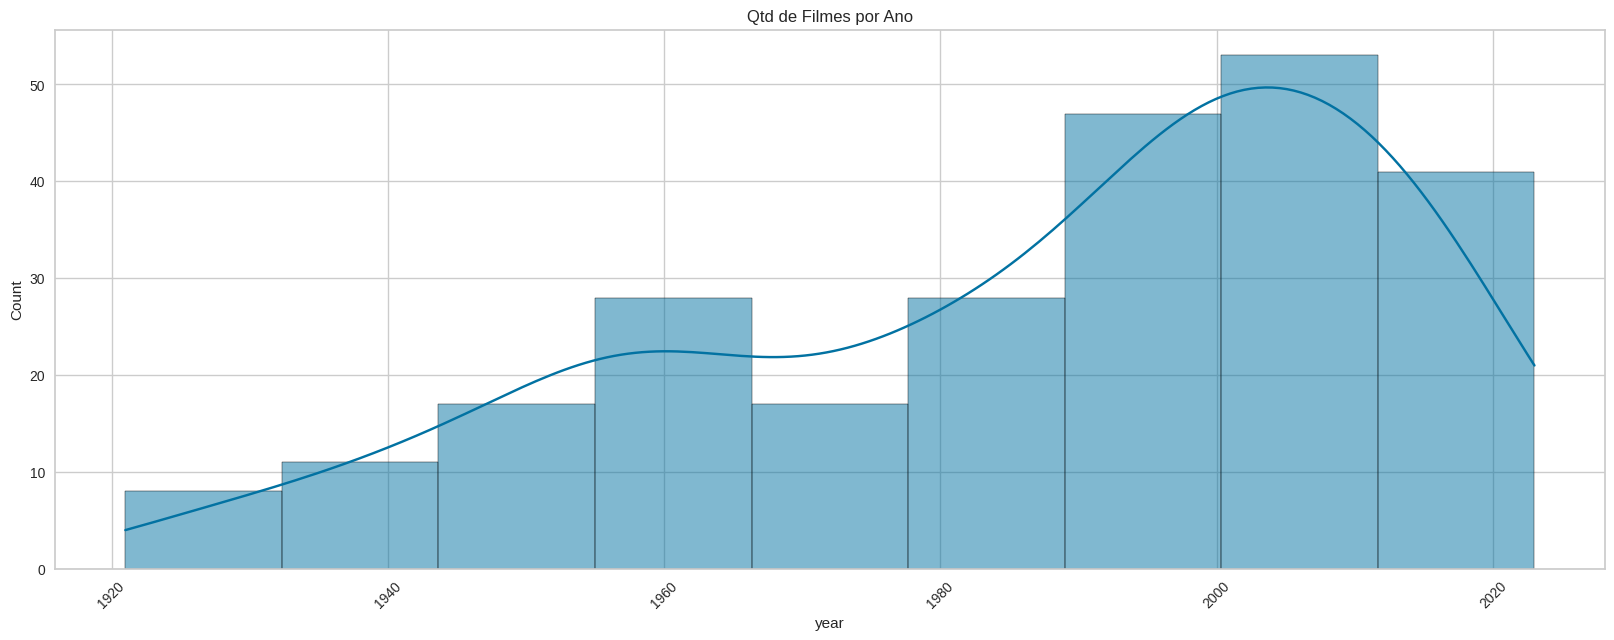

In [23]:
plt.figure(figsize = (20,7))
sns.histplot( df,
              x = 'year',
              kde = True).set_title('Qtd de Filmes por Ano')
plt.xticks(rotation=45)
plt.show()

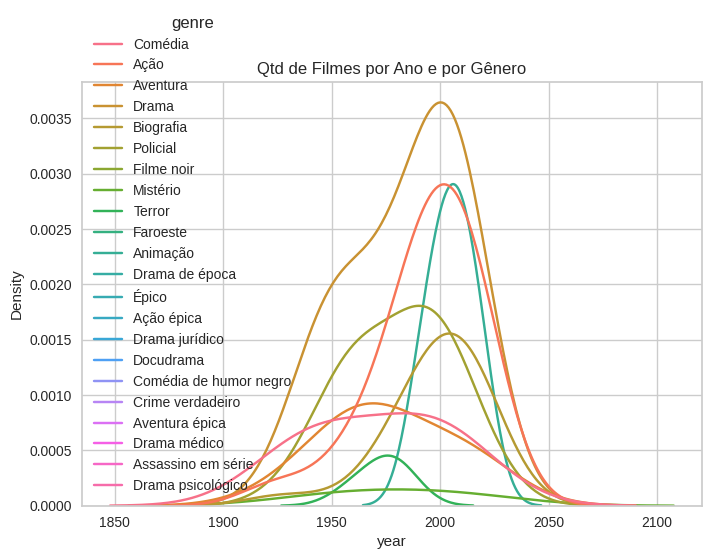

In [24]:
sns.kdeplot( df, x = 'year', hue = 'genre', bw_adjust = 1.5, warn_singular = False).set_title('Qtd de Filmes por Ano e por Gênero')
plt.show()

# Pré-processamento de texto

In [25]:
#convert sinopses to lowercase
df_processed = df.copy()
df_processed['sinopse'] = df_processed['sinopse'].str.lower()
df_processed['sinopse'].head()

130    um mendigo cuida de uma criança abandonada, ma...
197    um projecionista de cinema deseja ser um detet...
182    um garimpeiro vai ao klondike em busca de ouro...
190    uns espiões roubam a amada locomotiva de um en...
116    numa cidade futurística dividida entre os trab...
Name: sinopse, dtype: object

In [26]:
def qty_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [27]:
df_processed['word_count'] = df_processed['sinopse'].apply(qty_words).astype('int64')
df_processed.head()

title_pt            title_en    year  rating     genre  \
130          O Garoto        131. The Kid  1921.0     8.2   Comédia   
197  Bancando o Águia   198. Sherlock Jr.  1924.0     8.2      Ação   
182  Em Busca do Ouro  183. The Gold Rush  1925.0     8.1  Aventura   
190         A General    191. The General  1926.0     8.1      Ação   
116        Metrópolis     117. Metropolis  1927.0     8.3     Drama   

                                               sinopse  word_count  
130  um mendigo cuida de uma criança abandonada, ma...          13  
197  um projecionista de cinema deseja ser um detet...          31  
182  um garimpeiro vai ao klondike em busca de ouro...          15  
190  uns espiões roubam a amada locomotiva de um en...          17  
116  numa cidade futurística dividida entre os trab...          20

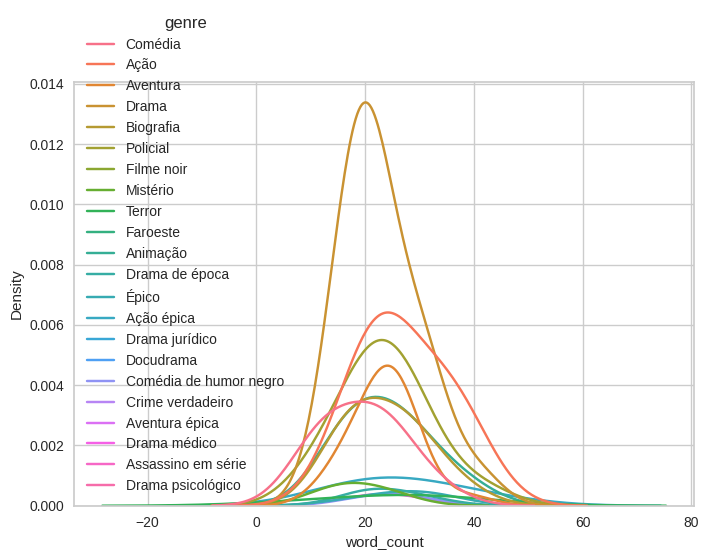

In [28]:
sns.kdeplot( df_processed, x = 'word_count', hue = 'genre', bw_adjust = 1.5, warn_singular = False)
plt.show()

## Nuvem de palavras

### Antes de remover stopwords

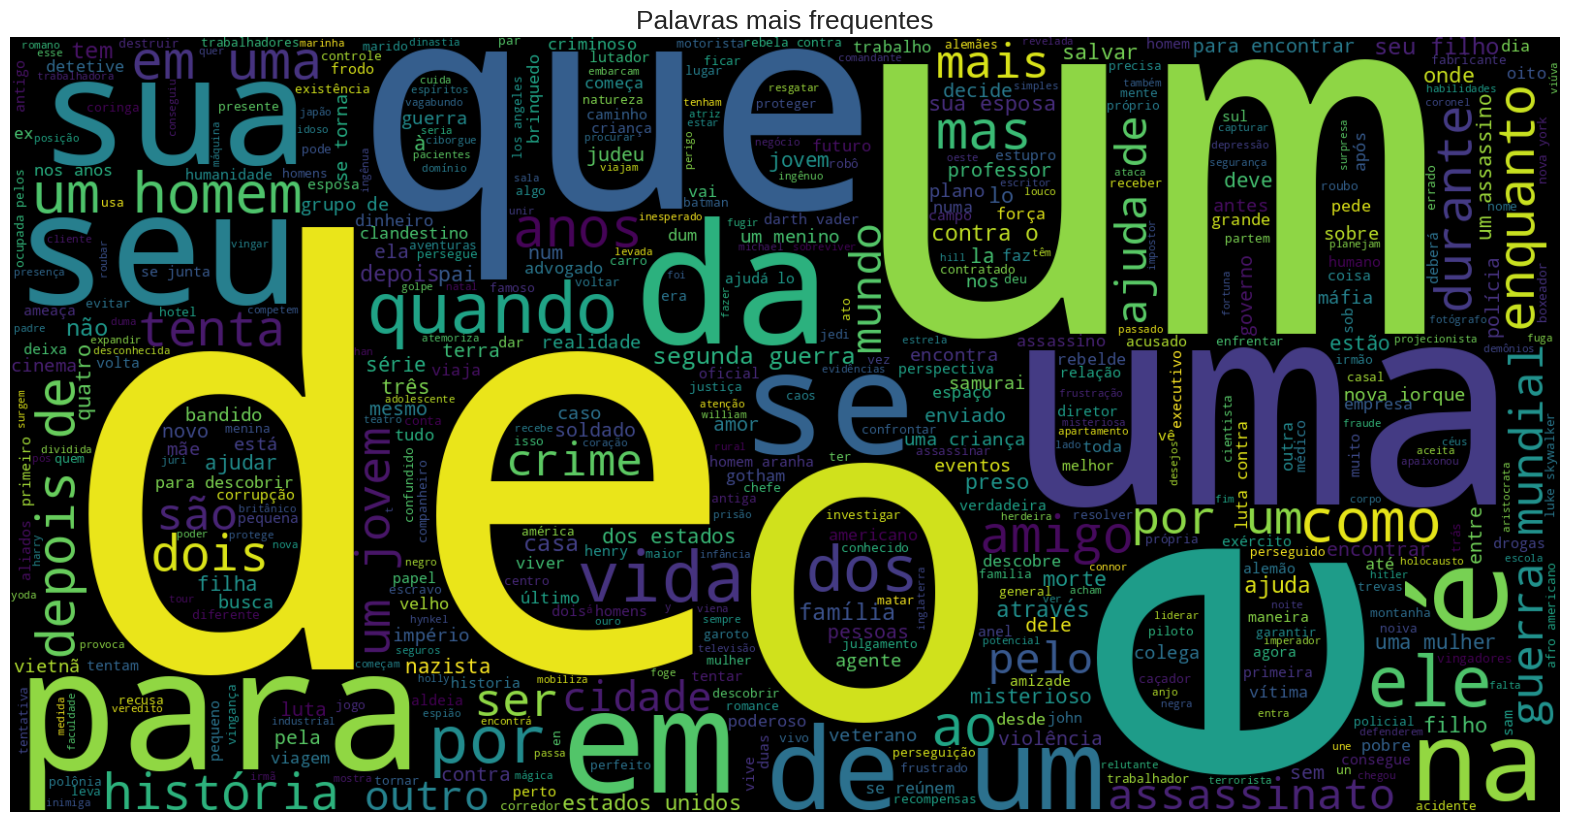

In [29]:
text = ' '.join([phrase for phrase in df_processed['sinopse']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes', fontsize = 19)
plt.show()

### Após remoção das stopwords

In [30]:
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('portuguese')
print(stopwords)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


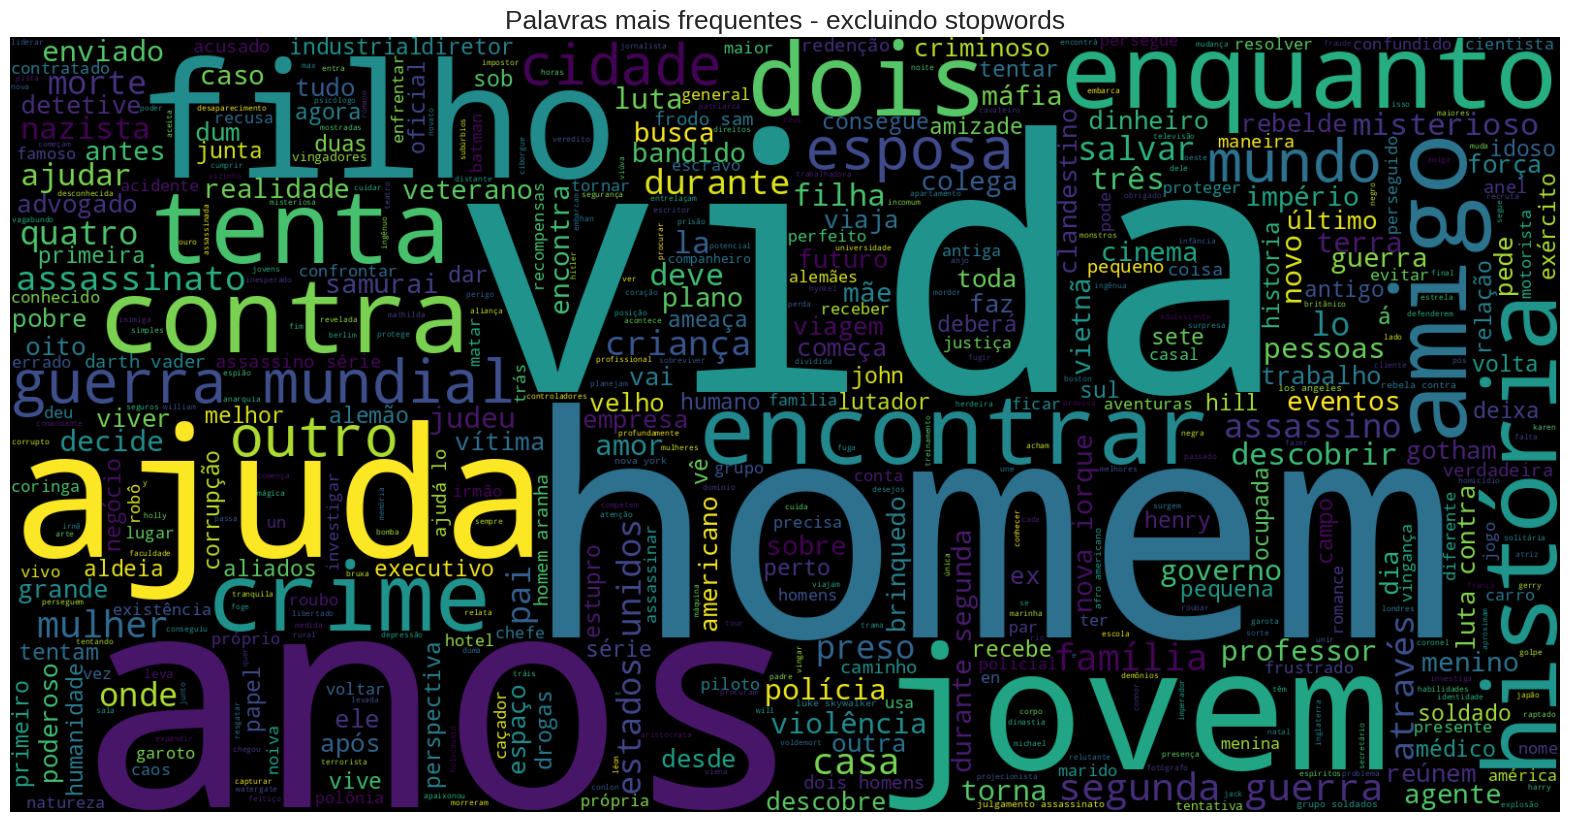

In [31]:
df_processed['sinopse_no_stopwords'] = df_processed['sinopse'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
text = ' '.join([phrase for phrase in df_processed['sinopse_no_stopwords']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes - excluindo stopwords', fontsize = 19)
plt.show()

## Aplicando TF-IDF

In [32]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=.05, max_df=0.95, ngram_range=(1,2))
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df_processed['sinopse_no_stopwords'])

In [33]:
print(X.shape)
X.toarray()

(275, 15)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# KMeans - Clusterização

## Escolhendo o numero de "k" clusters ideal

### Método Elbow

In [34]:
df_processed

title_pt                  title_en    year  rating  \
130                    O Garoto              131. The Kid  1921.0     8.2   
197            Bancando o Águia         198. Sherlock Jr.  1924.0     8.2   
182            Em Busca do Ouro        183. The Gold Rush  1925.0     8.1   
190                   A General          191. The General  1926.0     8.1   
116                  Metrópolis           117. Metropolis  1927.0     8.3   
..                          ...                       ...     ...     ...   
270  A Felicidade Não se Compra     It's a Wonderful Life     NaN     8.6   
271    O Silêncio dos Inocentes  The Silence of the Lambs     NaN     8.6   
272            Os Sete Samurais             Seven Samurai     NaN     8.6   
273   O Resgate do Soldado Ryan       Saving Private Ryan     NaN     8.6   
274      À Espera de um Milagre            The Green Mile     NaN     8.6   

                  genre                                            sinopse  \
130             Comédia  um mendigo cuida de uma criança abandonada, ma...   
197                Ação  um projecionista de cinema deseja ser um detet...   
182            Aventura  um garimpeiro vai ao klondike em busca de ouro...   
190                Ação  uns espiões roubam a amada locomotiva de um en...   
116               Drama  numa cidade futurística dividida entre os trab...   
..                  ...                                                ...   
270   Drama psicológico  um anjo é enviado dos céus para ajudar um home...   
271  Assassino em série  uma jovem deve receber a ajuda de um assassino...   
272          Ação épica  uma aldeia pobre sob a ameaça de bandidos recr...   
273      Drama de época  depois de chegar a normandía, um grupo de sold...   
274      Drama de época  as vidas dos guardas de corredor da morte são ...   

     word_count                               sinopse_no_stopwords  
130          13  mendigo cuida criança abandonada, eventos amea...  
197          31  projecionista cinema deseja detetive coloca ma...  
182          15  garimpeiro vai klondike busca ouro encontra isso.  
190          17  uns espiões roubam amada locomotiva engenheiro...  
116          20  cidade futurística dividida trabalhadores plan...  
..          ...                                                ...  
270          28  anjo enviado céus ajudar homem negócios desesp...  
271          27  jovem deve receber ajuda assassino canibal man...  
272          16  aldeia pobre sob ameaça bandidos recruta sete ...  
273          21  chegar normandía, grupo soldados precisa encon...  
274          30  vidas guardas corredor morte afetadas detidos:...  

[275 rows x 8 columns]

2 150.96988507422986
3 133.62902874673978
4 123.96286422848189
5 111.72769320122838
6 96.04746754321086
7 86.25900033365491
8 80.92653253184075
9 71.5956528476267
10 66.61299645478071
11 51.52249725339312
12 48.173105542907855
13 40.017498864994245
14 36.6727763886891
15 31.182434953465435
16 27.0905497950919
17 26.28580489925478
18 26.289356865820462
19 24.306781640738443
20 23.683233416195826
21 21.966777419394994
22 22.091156829664392


Text(0, 0.5, 'WCSS')

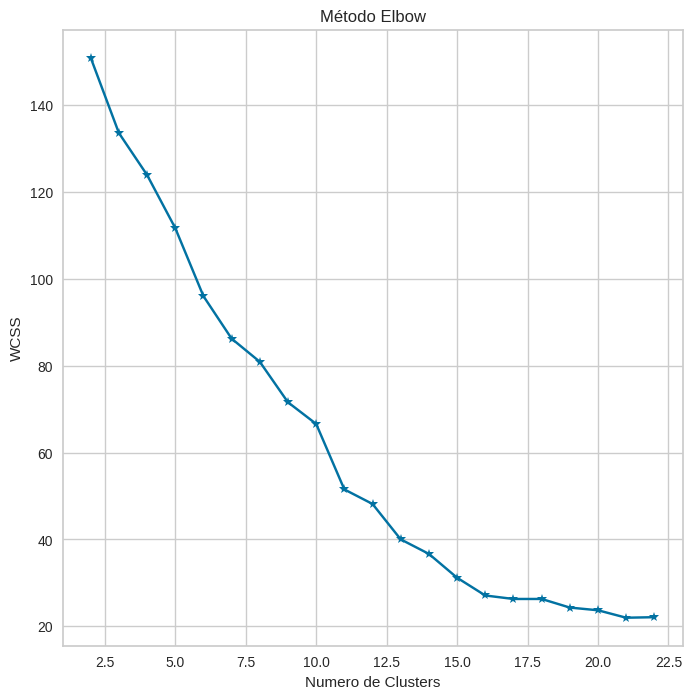

In [35]:
plt.figure(figsize = (8,8))

#plotando o grafico do método elbow
wcss = []

for i in range(2, df_processed.genre.nunique()+1):
  kmeans = KMeans(n_clusters = i, init = 'random')
  kmeans.fit(X)
  print(i, kmeans.inertia_)
  wcss.append(kmeans.inertia_)

plt.plot(range(2, df_processed.genre.nunique()+1), wcss, '*-')
plt.title('Método Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WCSS') #within cluster sum of square


### Método Silhouette

In [36]:
df_processed.genre.nunique()

22

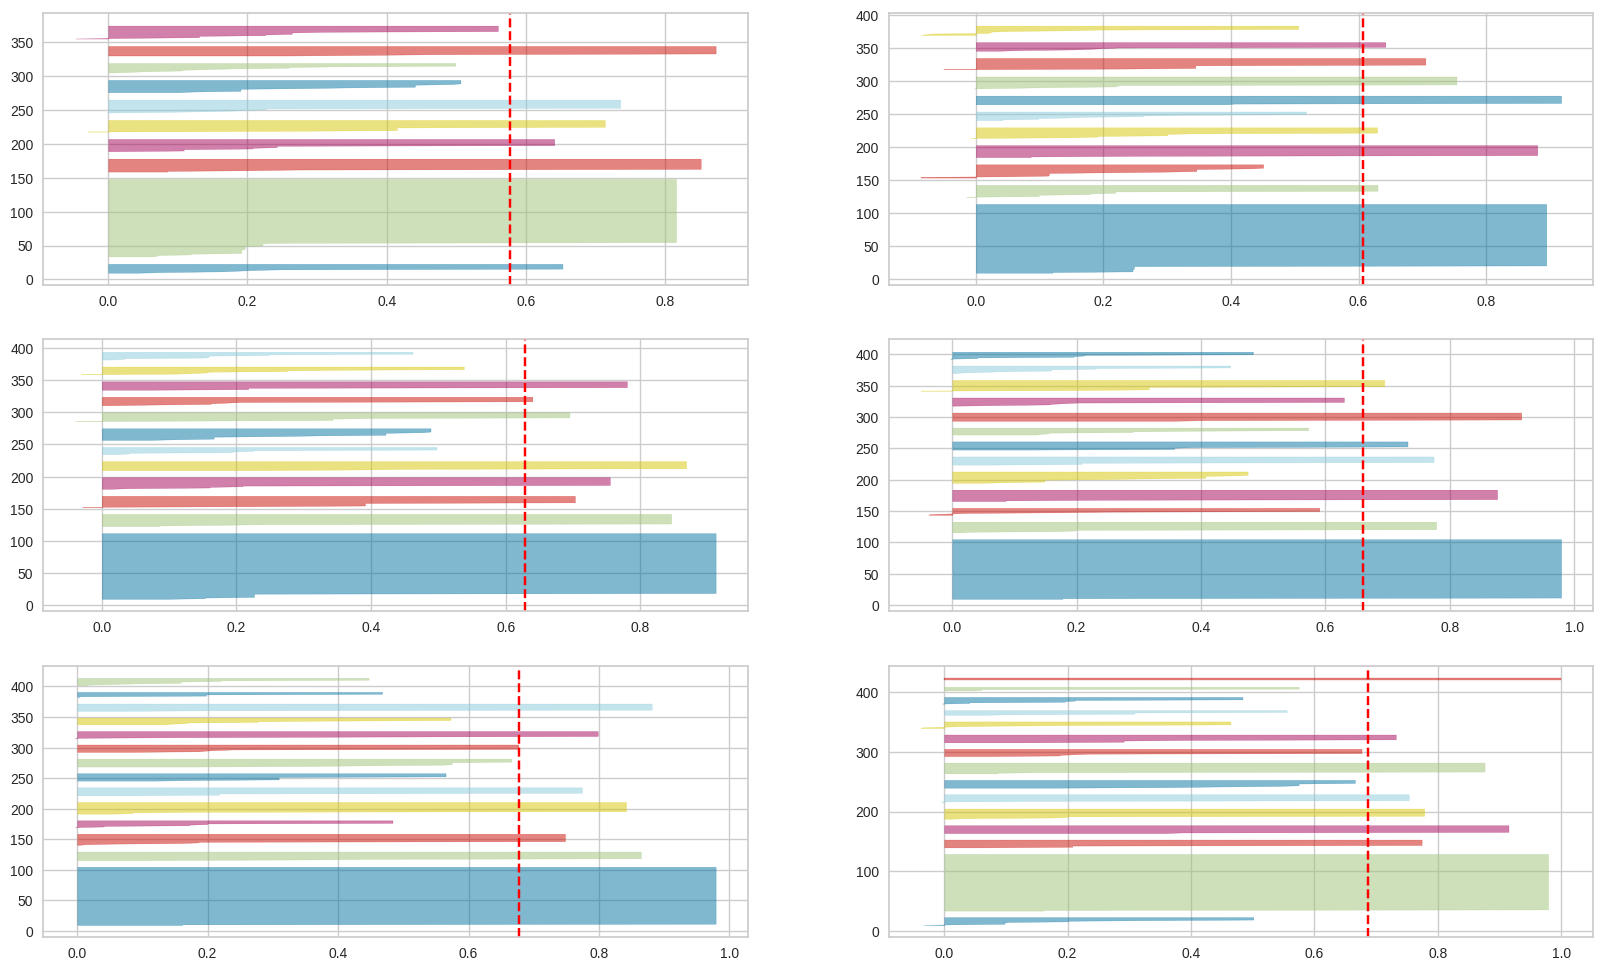

In [37]:
# fig, ax = plt.subplots(3,2, figsize = (20,12))
# for i in (range(10, 17)):
#   #Creating KMeans instance for different number of clusters
#   kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 42)
#   q, mod = divmod(i,2)

#   #Creating SilhouetteVisualizer instance with KMeans instance
#   #Fit the visualizer

#   visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax = ax[q-1][mod])
#   visualizer.fit(X)

fig, ax = plt.subplots(3,2, figsize = (20,12))
for i in range(6):  # Adjusted loop to match the number of subplots
    #Creating KMeans instance for different number of clusters
    kmeans = KMeans(n_clusters = i + 10, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 42)
    q, mod = divmod(i, 2)  # Calculate row and column indices

    #Creating SilhouetteVisualizer instance with KMeans instance
    #Fit the visualizer

    visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax = ax[q][mod])  # Access correct subplot
    visualizer.fit(X)

### Análise do número de clusters
* O método de elbow indicou um numero de k ideal entre 10 e 15. Pelo método de Silhouete não ficou muito claro, mas para k acima de 12 o aumento no valor da Silhouete (eixo x) é pequeno a cada k. Para efeitos didáticos, será adotado k=5 para facilitar as análises, mas em um projeto real deve ser testado o numero de k indicado pelos 2 métodos.

# Comparativo entre os 5 clusters

In [38]:
# initialize kmeans with 5 centroids
kmeans = KMeans(n_clusters=5, random_state=42)
# fit the model
kmeans = kmeans.fit(X)
#predicting the clusters and store cluster labels in a variable
labels = kmeans.predict(X)
#getting the cluster centers
c = kmeans.cluster_centers_

df_processed['cluster'] = labels
df_processed.head()

title_pt            title_en    year  rating     genre  \
130          O Garoto        131. The Kid  1921.0     8.2   Comédia   
197  Bancando o Águia   198. Sherlock Jr.  1924.0     8.2      Ação   
182  Em Busca do Ouro  183. The Gold Rush  1925.0     8.1  Aventura   
190         A General    191. The General  1926.0     8.1      Ação   
116        Metrópolis     117. Metropolis  1927.0     8.3     Drama   

                                               sinopse  word_count  \
130  um mendigo cuida de uma criança abandonada, ma...          13   
197  um projecionista de cinema deseja ser um detet...          31   
182  um garimpeiro vai ao klondike em busca de ouro...          15   
190  uns espiões roubam a amada locomotiva de um en...          17   
116  numa cidade futurística dividida entre os trab...          20   

                                  sinopse_no_stopwords  cluster  
130  mendigo cuida criança abandonada, eventos amea...        1  
197  projecionista cinema deseja detetive coloca ma...        1  
182  garimpeiro vai klondike busca ouro encontra isso.        1  
190  uns espiões roubam amada locomotiva engenheiro...        1  
116  cidade futurística dividida trabalhadores plan...        1

## Filmes por cluster

In [39]:
fig = px.bar(df_processed.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

## % de Gêneros por Cluster

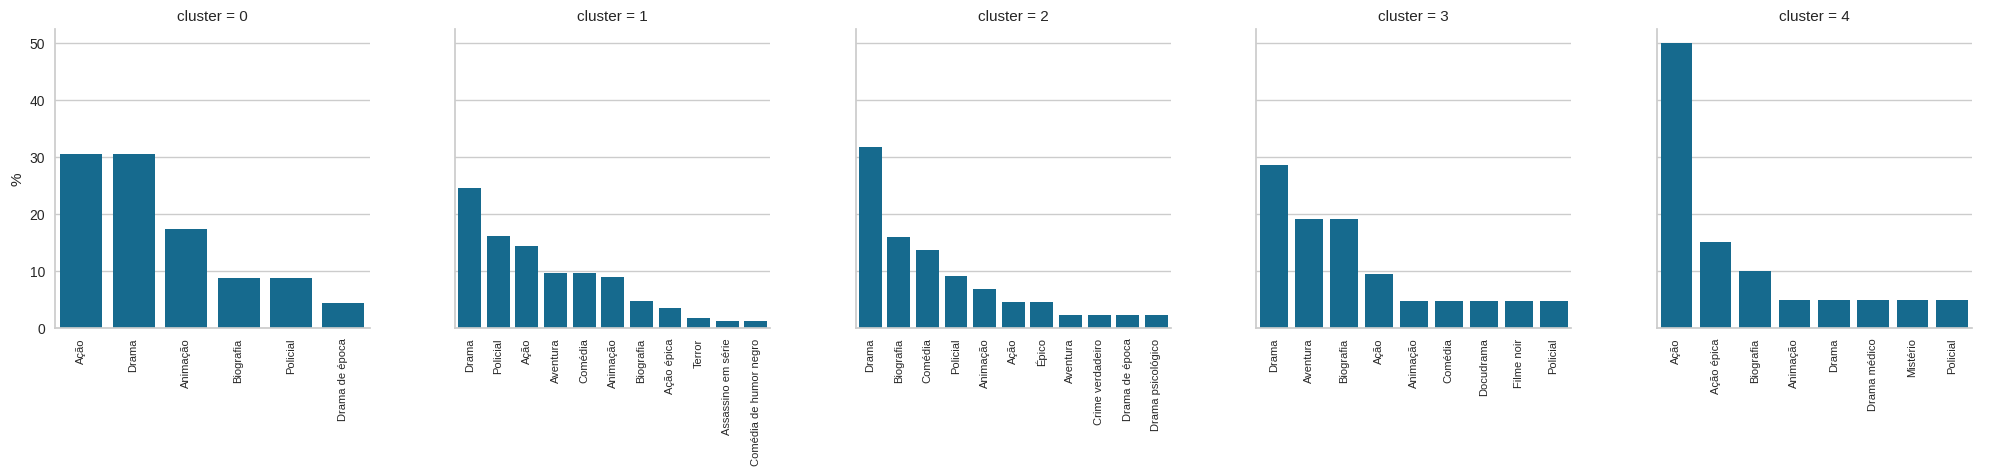

In [40]:
df_plot = df_processed.groupby(['cluster', 'genre'])['title_pt'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_pt':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

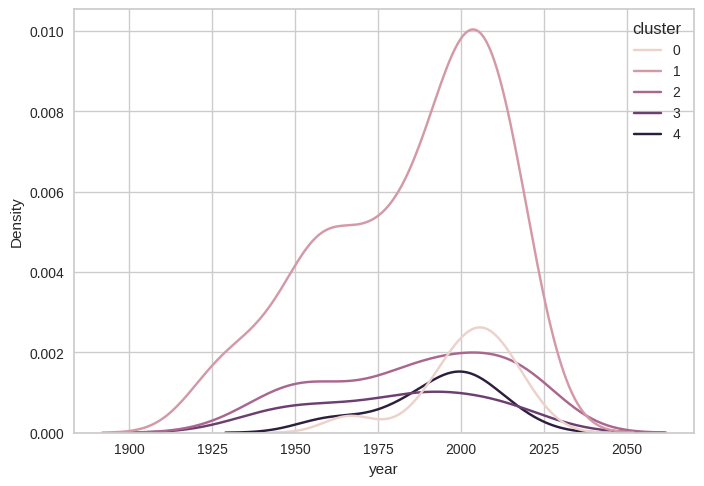

In [41]:
sns.kdeplot(df_processed, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [42]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'genre', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

cluster                   genre          0          1          2          3  \
0                      Animação  17.391304   8.982036   6.818182   4.761905   
1            Assassino em série   0.000000   1.197605   0.000000   0.000000   
2                      Aventura   0.000000   9.580838   2.272727  19.047619   
3                          Ação  30.434783  14.371257   4.545455   9.523810   
4                    Ação épica   0.000000   3.592814   0.000000   0.000000   
5                     Biografia   8.695652   4.790419  15.909091  19.047619   
6                       Comédia   0.000000   9.580838  13.636364   4.761905   
7        Comédia de humor negro   0.000000   1.197605   0.000000   0.000000   
8              Crime verdadeiro   0.000000   0.000000   2.272727   0.000000   
9                     Docudrama   0.000000   0.000000   0.000000   4.761905   
10                        Drama  30.434783  24.550898  31.818182  28.571429   
11               Drama de época   4.347826   0.000000   2.272727   0.000000   
12                 Drama médico   0.000000   0.000000   0.000000   0.000000   
13            Drama psicológico   0.000000   0.000000   2.272727   0.000000   
14                   Filme noir   0.000000   0.000000   0.000000   4.761905   
15                     Mistério   0.000000   0.000000   0.000000   0.000000   
16                     Policial   8.695652  16.167665   9.090909   4.761905   
17                       Terror   0.000000   1.796407   0.000000   0.000000   
18                        Épico   0.000000   0.000000   4.545455   0.000000   

cluster     4  
0         5.0  
1         0.0  
2         0.0  
3        50.0  
4        15.0  
5        10.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  
10        5.0  
11        0.0  
12        5.0  
13        0.0  
14        0.0  
15        5.0  
16        5.0  
17        0.0  
18        0.0

In [43]:
df_polar = df_pivot.melt(id_vars=['genre'])
df_polar.head()

genre cluster      value
0            Animação       0  17.391304
1  Assassino em série       0   0.000000
2            Aventura       0   0.000000
3                Ação       0  30.434783
4          Ação épica       0   0.000000

In [44]:
fig = px.line_polar(df_polar, r='value', theta='genre', color = 'cluster', line_close=True)
fig.show();

# Nuvem de Palavras por Cluster

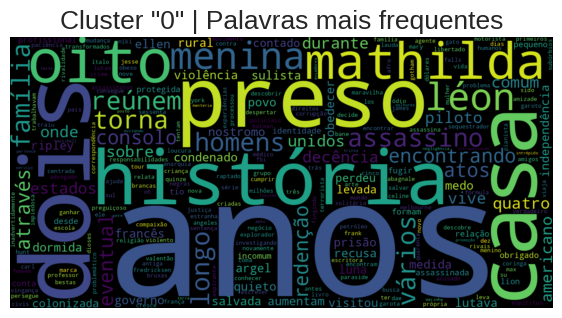

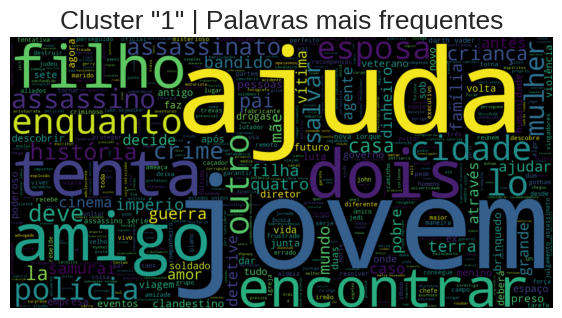

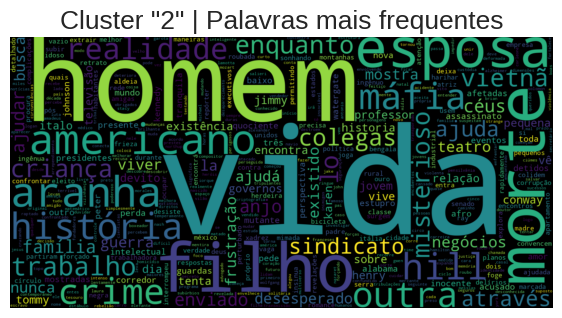

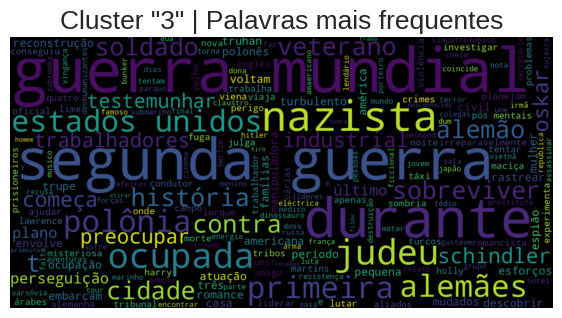

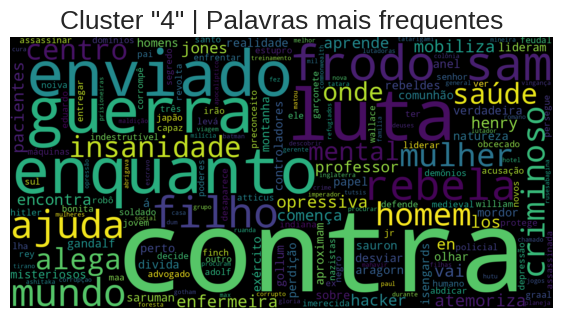

In [45]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_processed.loc[df_processed.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

for c in range(5):
  word_cloud_cluster(c)

# Considerações Finais

** Na seção "Comparativo entre os 5 clusters" foram apresentadas diferentes formas de caracterizar cada cluster.**

Considere as afirmações abaixo apenas como exemplo, e reescreva-as conforme o seu entendimento.

1. Primeiro foi demonstrado que o cluster #2 foi o que apresentou o maior número de amostras (filmes). _(Idealmente os cluster devem conter quantidades balanceadas, porém neste projeto, por ter um dataset com baixo número de amostras (275
), não foi possível atender esta premissa)_.

2. Depois foi analisado o % de cada gênero por cluster, sendo os dois gêneros mais representativos do:

  2.1 Cluster 0: Animação e Drama

  2.2 Cluster 1: Biografia e Aventura

  2.3 Cluster 2: Drama e Ação

  2.4 Cluster 3: Drama e Biografia

  2.5 Cluster 4: Drama e Comédia


3. Na sequência foi avaliado a distribuição dos anos de lançamento dos filmes por cluster, sem diferença siginificativa entre eles, com maior concentração ao redor do ano 2000.

4. Depois foi apresentado um gráfico de radar por cluster, onde a exemplo do item 2, é possível avaliar a representatividade de cada gênero por cluster.

5. E finalmente, foram apresentadas as nuvens de palavras por cluster, onde em linhas gerais destacam-se:

  5.1 o Cluster 0 com temas sobre Guerra Mundial, Luta, Judeus, Alemães

  5.2 O Cluster 1 e 3 com temas de disputa como Contra, Morte, Advogado, Homem,Polícia

  5.3 o Cluster 2 com temas do cotidiano como Filhos, Amigos, Ajuda, Jovem, Família

  5.4 o Cluster 4 com temas de auto-conhecimento como Busca, Encontrar, Descobrir, Casa, Terra


** Em resumo neste projeto foram aplicados conceitos de:

1. Webscraping / Crawler para coleta de dados do site IMDb
2. Pré-processamento de texto com utilização de técnicas de NLP
3. Clusterização

Desta forma consideramos que o objetivo inicial foi atingido sendo possível a clusterização dos filmes baseado na sinopse / descrição de cada um, gerando desta forma a possibilidade de recomendar filmes aos usuários não apenas pela classificação tradicional por gêneros, mas também pelos clusters identificados neste projeto.

**Em termos práticos, se um usuário avalia positivamente um filme, os filmes pertecentes ao mesmo cluster podem ser recomendados a ele.**